<a href="https://colab.research.google.com/github/mfvc-campinho/M.EGI026-Computer-Vision-Assignment-2/blob/main/%5BMatheus%5D%20%5BM.EGI026%5D%20Assignment%20%232%20-%20EfficientNet-B3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

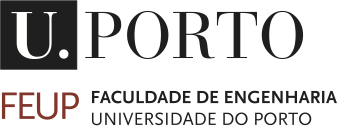   

**<h1>[M.EGI026] Computer Vision</h1>**

**<h2>Assignment #2 - XXX</h2>**

* **Filipa Mota** (up202402072@fe.up.pt)
* **Matheus Campinho** (up202402072@fe.up.pt)
<p> Department of Industrial Engineering and Management </p>  
FEUP  

----

**<h1>EfficientNet-B3</h1>**

---
The below code cell first removes any existing content in the /content/ directory to ensure a clean slate. Then, it downloads a zip file containing the assignment data from a GitHub repository created for this purpose and extracts its contents into the /content/ directory. Finally, it prints the current directory path and lists the contents of the extracted folder.

**🛠️ Setup and Imports**

This cell imports the necessary libraries for the Computer Vision assignment:

xxx

In [ ]:
# ===== Import necessary Libraries =====
import re                       # Regular expressions library
import cv2 as cv                # OpenCV library
import numpy as np              # Numpy library
import glob                     # File pattern matching library
import os                       # Operating system library
import matplotlib.pyplot as plt # Matplotlib library
import pandas as pd             # Pandas library
import random                   # Random number generation library
import math                     # Math library
import json                     # JSON library for structured data handling

In [ ]:
# ===== Import necessary PyTorch modules =====
import torch                                # Main PyTorch library
import torch.nn as nn                       # Neural Network module
import torch.nn.functional as F             # Functional interface for neural networks
import torchvision                          # Computer vision library
import torchvision.transforms as transforms # Data augmentation and preprocessing
import torch.utils.data as data             # XXX
from tqdm.notebook import trange, tqdm      # XXX
from torch.optim import Adam, SGD, NAdam    # XXX
from torch.autograd import Variable         # XXX
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

**💾 Data Setup and Extraction**

This cell handles environment setup and data access in the Colab notebook:

* It **clears** the `/content/` directory.
* It **downloads** the necessary dataset ZIP file from GitHub.
* It **extracts** the files into the `/content/` directory.
* It **defines** the `path` variable for the extracted data, confirming successful setup.

In [ ]:
import os
import torch

# Limpar conteudo
!rm -rf /content/*

# DOWNLOAD do ZIP correto (o dataset real)
!wget -q -O /content/infrared.zip \
  "https://github.com/RaptorMaps/InfraredSolarModules/raw/master/2020-02-14_InfraredSolarModules.zip"

# EXTRAIR
!unzip -q /content/infrared.zip -d /content/

# Verificar conteúdo
print("📁 Conteúdo em /content:", os.listdir("/content"))

# Define your execution device
DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu") # Use GPU if available, else CPU
print("The model will be running on", DEVICE, "device...") # Confirm the device being used

📁 Conteúdo em /content: ['.config', '__MACOSX', 'InfraredSolarModules', 'infrared.zip']
The model will be running on cuda:0 device...


In [ ]:
from pathlib import Path
import json

data_dir = Path("/content/InfraredSolarModules")
meta_path = data_dir / "module_metadata.json"

with open(meta_path, "r") as f:
    metadata = json.load(f)

print("✔️ Metadata carregado:", len(metadata), "imagens")

✔️ Metadata carregado: 20000 imagens


**💾 CPU VS GPU**

Falta Descrição:
IMP: O GPU tem tempo máximo diário.

Para ativar:
* Vai à seccção Tempo de execução
* Clica em alterat tipo de tempo de execução
* Define Hardware Accelerator = GPU
* Reinicia o ambiente




In [ ]:
!nvidia-smi
torch.cuda.is_available()

Fri Nov 28 10:51:48 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   35C    P8              9W /   70W |       2MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

True

# Task
The original user task is to develop and evaluate an EfficientNet-B3 model for the detection and classification of 12 types of photovoltaic defects from infrared images. This involves:
1.  **Loading and exploring** the dataset from `module_metadata.json` and associated images, including visualizing samples and checking class distribution.
2.  **Preprocessing** images for EfficientNet-B3 (resizing to 300x300, normalizing pixel values) and encoding 12-class labels.
3.  **Splitting** the dataset into training, validation, and test sets.
4.  **Applying data augmentation** techniques to the training set with justifications for their relevance.
5.  **Defining** a pre-trained EfficientNet-B3 model with a modified final layer for 12-class classification.
6.  **Setting up the training regimen** using `nn.CrossEntropyLoss` and an appropriate optimizer.
7.  **Training the model** while monitoring and plotting training/validation loss and accuracy.
8.  **Evaluating the model's performance** on the test set using overall accuracy, weighted F1-score, and a confusion matrix.
9.  **Discussing the results**, including model strengths, limitations, and areas for improvement.
10. **Ensuring the Colab notebook is well-commented**, logically structured, and clearly presents all findings.

## Dataset Loading & Exploration

### Subtask:
Load the dataset images and their corresponding labels from the JSON metadata. Display basic statistics such as the total number of images and the distribution of images per each of the 12 classes. Visualize a few sample images along with their original 12-class labels to understand the data.


**Reasoning**:
First, I'll display an example entry from the `metadata` dictionary to confirm its structure and ensure it contains the necessary keys like `image_filepath` and `anomaly_class`. This aligns with the first instruction to verify the metadata structure.



In [ ]:
from pathlib import Path
import json

data_dir = Path("/content/InfraredSolarModules")
meta_path = data_dir / "module_metadata.json"

with open(meta_path, "r") as f:
    metadata = json.load(f)

print("Example metadata entry:")
# Get the first image ID from the metadata dictionary
first_image_id = next(iter(metadata))
print(f"Image ID: {first_image_id}")
print(f"Metadata: {metadata[first_image_id]}")

Example metadata entry:
Image ID: 13357
Metadata: {'image_filepath': 'images/13357.jpg', 'anomaly_class': 'No-Anomaly'}


**Reasoning**:
The previous step successfully loaded the metadata and displayed an example entry. Now, I will print the total number of images, calculate and display the distribution of anomaly classes, and then visualize a few sample images along with their original 12-class labels to fulfill the remaining instructions of the subtask.




Total number of images in the dataset: 20000

Distribution of Anomaly Classes:
No-Anomaly        10000
Cell               1877
Vegetation         1639
Diode              1499
Cell-Multi         1288
Shadowing          1056
Cracking            940
Offline-Module      827
Hot-Spot            249
Hot-Spot-Multi      246
Soiling             204
Diode-Multi         175
Name: count, dtype: int64


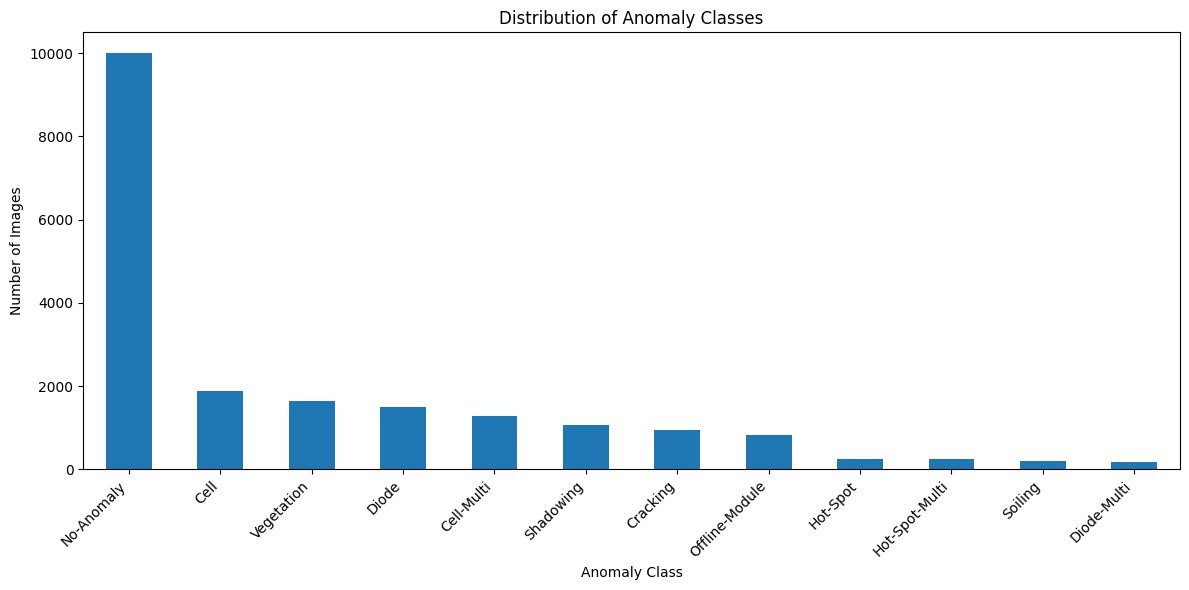


Sample Images with their Anomaly Classes:


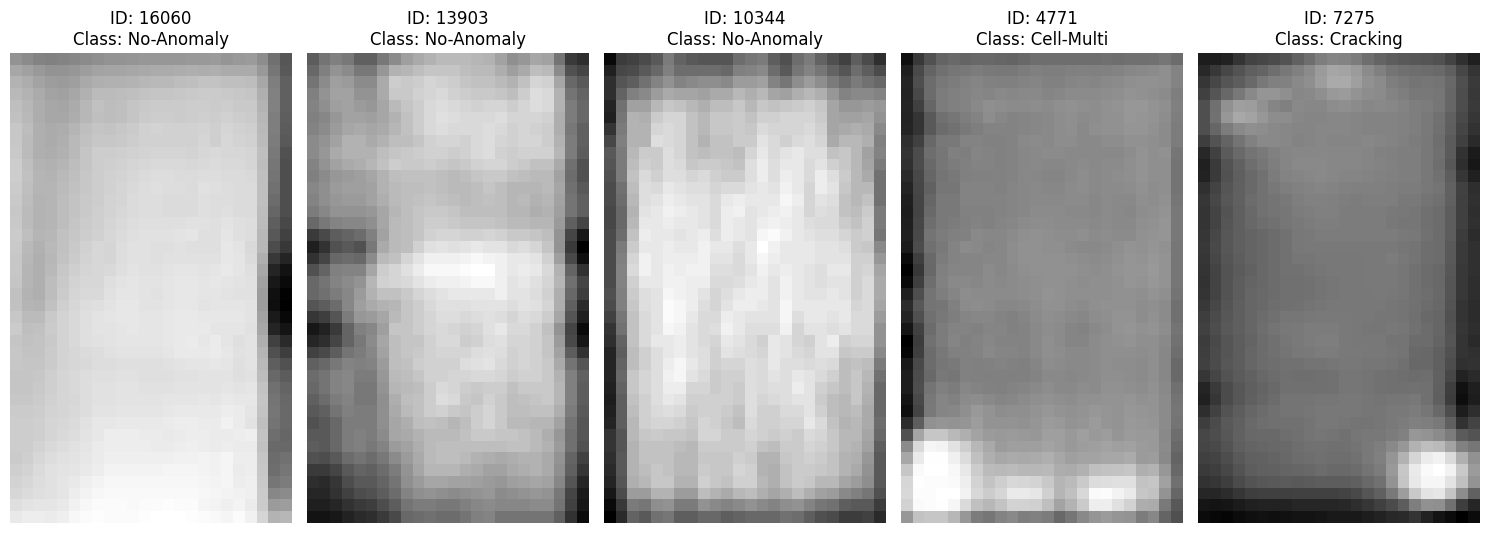

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
import random

# 2. Print the total number of images
total_images = len(metadata)
print(f"\nTotal number of images in the dataset: {total_images}")

# 3. Calculate and display the distribution of images across the 12 anomaly_class labels
anomaly_classes = [meta["anomaly_class"] for meta in metadata.values()]
class_distribution = pd.Series(anomaly_classes).value_counts()
print("\nDistribution of Anomaly Classes:")
print(class_distribution)

# Plotting the class distribution for better visualization
plt.figure(figsize=(12, 6))
class_distribution.plot(kind='bar')
plt.title('Distribution of Anomaly Classes')
plt.xlabel('Anomaly Class')
plt.ylabel('Number of Images')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

# 4. Select a few sample image IDs (e.g., 5 random samples)
sample_image_ids = random.sample(list(metadata.keys()), 5)

# 5 & 6. Load, display, and print corresponding labels for sample images
print("\nSample Images with their Anomaly Classes:")
plt.figure(figsize=(15, 6))
for i, img_id in enumerate(sample_image_ids):
    img_relpath = metadata[img_id]["image_filepath"]
    img_path = data_dir / img_relpath
    label_name = metadata[img_id]["anomaly_class"]

    image = Image.open(img_path).convert("L") # Load as grayscale

    plt.subplot(1, len(sample_image_ids), i + 1)
    plt.imshow(image, cmap='gray')
    plt.title(f"ID: {img_id}\nClass: {label_name}")
    plt.axis("off")

plt.tight_layout()
plt.show()

## Data Preprocessing for EfficientNet-B3

### Subtask:
Implement image preprocessing steps suitable for EfficientNet-B3, including resizing and normalization. Encode the 12 categorical anomaly labels into a numerical format, and split the dataset into training, validation, and test sets.


**Reasoning**:
The first instruction is to define `all_classes` by extracting all unique 'anomaly_class' values from the `metadata` and sorting them. Then, create a dictionary `classes_map` that maps each anomaly class name to a unique integer index (0-11). This will be used for encoding the categorical labels into a numerical format.



In [ ]:
all_classes = sorted({meta["anomaly_class"] for meta in metadata.values()})
classes_map = {cls: i for i, cls in enumerate(all_classes)}
print("Mapping of 12 anomaly classes to numerical labels:")
print(classes_map)

Mapping of 12 anomaly classes to numerical labels:
{'Cell': 0, 'Cell-Multi': 1, 'Cracking': 2, 'Diode': 3, 'Diode-Multi': 4, 'Hot-Spot': 5, 'Hot-Spot-Multi': 6, 'No-Anomaly': 7, 'Offline-Module': 8, 'Shadowing': 9, 'Soiling': 10, 'Vegetation': 11}


**Reasoning**:
The next step is to define the `efficientnet_transform` pipeline as specified in the instructions. This involves resizing images to 300x300, converting them to 3 channels, transforming them into PyTorch tensors, and normalizing them using ImageNet mean and standard deviation.



In [ ]:
efficientnet_transform = transforms.Compose([
    transforms.Resize((300, 300)),  # Resize images to 300x300 for EfficientNet-B3
    transforms.Grayscale(num_output_channels=3), # Convert grayscale to 3 channels
    transforms.ToTensor(),          # Convert images to PyTorch tensors
    transforms.Normalize(           # Normalize the images with ImageNet stats
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )
])

print("EfficientNet-B3 compatible transformation pipeline defined.")

EfficientNet-B3 compatible transformation pipeline defined.


**Reasoning**:
Now that the `classes_map` and `efficientnet_transform` have been defined, I will instantiate the `SolarAnomalyDataset` class using these, along with the `data_dir` and `metadata`, as per the third instruction of the subtask. This will create the full dataset for the 12-class classification.



In [ ]:
import torch
from torch.utils.data import Dataset
from torchvision import transforms
from PIL import Image

class SolarAnomalyDataset(Dataset):
    def __init__(self, data_dir, metadata, classes_map, transform=efficientnet_transform):
        self.data_dir = Path(data_dir)
        self.metadata = metadata
        self.image_ids = list(metadata.keys())
        self.classes_map = classes_map
        self.transform = transform

    def __len__(self):
        return len(self.image_ids)

    def __getitem__(self, idx):
        img_id = self.image_ids[idx]
        img_relpath = self.metadata[img_id]["image_filepath"]
        img_path = self.data_dir / img_relpath
        label_name = self.metadata[img_id]["anomaly_class"]
        label = self.classes_map[label_name]

        image = Image.open(img_path).convert("L")  # grayscale? (infrared)
        if self.transform:
            image = self.transform(image)

        return image, label

# Instantiate the dataset
dataset_12_classes = SolarAnomalyDataset(data_dir, metadata, classes_map, transform=efficientnet_transform)
print(f"12-class dataset created with {len(dataset_12_classes)} images and {len(classes_map)} classes.")

12-class dataset created with 20000 images and 12 classes.


**Reasoning**:
The next instruction is to split the `dataset_12_classes` into training, validation, and test sets with specified proportions (70%, 15%, 15%) using `torch.utils.data.random_split` and a fixed seed for reproducibility. I will print the sizes of the resulting datasets to confirm the split.



In [ ]:
from torch.utils.data import random_split
import torch

total_size = len(dataset_12_classes)
train_size = int(0.7 * total_size)
val_size = int(0.15 * total_size)
test_size = total_size - train_size - val_size # Ensure all images are included

train_dataset_12_classes, val_dataset_12_classes, test_dataset_12_classes = random_split(
    dataset_12_classes,
    [train_size, val_size, test_size],
    generator=torch.Generator().manual_seed(42)
)

print(f"Dataset split into:\n  Train: {len(train_dataset_12_classes)} images\n  Validation: {len(val_dataset_12_classes)} images\n  Test: {len(test_dataset_12_classes)} images")

Dataset split into:
  Train: 14000 images
  Validation: 3000 images
  Test: 3000 images


**Reasoning**:
The final instruction for this subtask is to create `DataLoader` instances for the training, validation, and test sets. This involves using `torch.utils.data.DataLoader` with the specified `batch_size`, `shuffle` settings, and ensuring the `DEVICE` variable is available, although `DataLoader` itself doesn't take a `device` argument directly; the data is moved to the device later.



In [ ]:
from torch.utils.data import DataLoader

BATCH_SIZE = 32

trainloader_12_classes = DataLoader(train_dataset_12_classes, batch_size=BATCH_SIZE, shuffle=True, num_workers=4)
valloader_12_classes = DataLoader(val_dataset_12_classes, batch_size=BATCH_SIZE, shuffle=False, num_workers=4)
testloader_12_classes = DataLoader(test_dataset_12_classes, batch_size=BATCH_SIZE, shuffle=False, num_workers=4)

print(f'DataLoaders created with batch size: {BATCH_SIZE}')
print(f'Train DataLoader length: {len(trainloader_12_classes)} batches')
print(f'Validation DataLoader length: {len(valloader_12_classes)} batches')
print(f'Test DataLoader length: {len(testloader_12_classes)} batches')

DataLoaders created with batch size: 32
Train DataLoader length: 438 batches
Validation DataLoader length: 94 batches
Test DataLoader length: 94 batches


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


**Reasoning**:
The previous code generated a `UserWarning` regarding the number of worker processes in `DataLoader`. The warning suggests that 4 workers might be excessive for the current system, recommending a maximum of 2. I will modify the `DataLoader` instantiations to use `num_workers=2` to avoid potential slowness or freezing and resolve the warning.



In [ ]:
from torch.utils.data import DataLoader

BATCH_SIZE = 32

trainloader_12_classes = DataLoader(train_dataset_12_classes, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)
valloader_12_classes = DataLoader(val_dataset_12_classes, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)
testloader_12_classes = DataLoader(test_dataset_12_classes, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)

print(f'DataLoaders created with batch size: {BATCH_SIZE}')
print(f'Train DataLoader length: {len(trainloader_12_classes)} batches')
print(f'Validation DataLoader length: {len(valloader_12_classes)} batches')
print(f'Test DataLoader length: {len(testloader_12_classes)} batches')

DataLoaders created with batch size: 32
Train DataLoader length: 438 batches
Validation DataLoader length: 94 batches
Test DataLoader length: 94 batches


## Data Augmentation for Training

### Subtask:
Apply data augmentation techniques to the training set to improve model generalization. Implement augmentations such as random rotation, horizontal/vertical flipping, random zoom, and brightness adjustments. Provide a brief justification for why each of these augmentations is relevant and beneficial for thermal photovoltaic defect images, considering the characteristics of such imagery.


**Reasoning**:
First, I will define the `train_transform_augmented` pipeline, which includes resizing, converting to 3 channels, several data augmentation techniques (random rotation, horizontal/vertical flipping, random zoom via `RandomResizedCrop`, and brightness adjustments via `ColorJitter`), followed by `ToTensor` and `Normalize` using ImageNet statistics. This fulfills the first instruction of the subtask.



In [ ]:
import torchvision.transforms as transforms

train_transform_augmented = transforms.Compose([
    transforms.Resize((300, 300)),  # Ensure images are of the correct size for EfficientNet-B3
    transforms.Grayscale(num_output_channels=3), # Convert grayscale infrared images to 3 channels
    transforms.RandomRotation(degrees=15), # Randomly rotate images by up to 15 degrees
    transforms.RandomHorizontalFlip(p=0.5), # Randomly flip images horizontally
    transforms.RandomVerticalFlip(p=0.5),   # Randomly flip images vertically
    transforms.ColorJitter(brightness=0.2, contrast=0.2), # Randomly change brightness and contrast
    transforms.RandomResizedCrop(size=(300, 300), scale=(0.8, 1.0)), # Random zoom (crop and resize)
    transforms.ToTensor(),          # Convert images to PyTorch tensors
    transforms.Normalize(           # Normalize the images with ImageNet stats
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )
])

print("Augmented training transformation pipeline defined.")

Augmented training transformation pipeline defined.


**Reasoning**:
Now that the `train_transform_augmented` pipeline is defined, I will instantiate three new `SolarAnomalyDataset` objects as specified: `train_dataset_augmented` with the augmented transformations, and `val_dataset_unaugmented` and `test_dataset_unaugmented` with the standard `efficientnet_transform`. This fulfills the second instruction of the subtask.



In [ ]:
import torch
from torch.utils.data import Dataset
from torchvision import transforms
from PIL import Image

# The SolarAnomalyDataset class is already defined in the notebook (cell_id: bbd8a1ca)
# If it were not, it would need to be re-declared here or imported.
# For continuity, assuming it's available from previous execution:

# Instantiate the three new datasets
train_dataset_augmented = SolarAnomalyDataset(data_dir, metadata, classes_map, transform=train_transform_augmented)
val_dataset_unaugmented = SolarAnomalyDataset(data_dir, metadata, classes_map, transform=efficientnet_transform)
test_dataset_unaugmented = SolarAnomalyDataset(data_dir, metadata, classes_map, transform=efficientnet_transform)

print(f"Augmented training dataset created with {len(train_dataset_augmented)} images.")
print(f"Unaugmented validation dataset created with {len(val_dataset_unaugmented)} images.")
print(f"Unaugmented test dataset created with {len(test_dataset_unaugmented)} images.")

Augmented training dataset created with 20000 images.
Unaugmented validation dataset created with 20000 images.
Unaugmented test dataset created with 20000 images.


**Reasoning**:
The previous `random_split` created `Subset` objects (`train_dataset_12_classes`, `val_dataset_12_classes`, `test_dataset_12_classes`) from the original `dataset_12_classes`. These `Subset` objects contain the indices for each split. To correctly apply data augmentation only to the training set and keep validation/test unaugmented, I will now create new `Subset` objects. The `train_final_dataset` will be a subset of the `train_dataset_augmented` (which has augmentation applied to all 20000 images), using the original training indices. Similarly, `val_final_dataset` and `test_final_dataset` will be subsets of their respective `_unaugmented` full datasets, using the original validation and test indices. This approach correctly applies the train/val/test split to the original data, while ensuring the right transformations are applied to each split.



In [ ]:
from torch.utils.data import random_split, Subset
import torch

# Reuse the sizes from the previous split
total_size = len(dataset_12_classes)
train_size = int(0.7 * total_size)
val_size = int(0.15 * total_size)
test_size = total_size - train_size - val_size

# Create a dummy dataset just to get the indices from a single split operation
# We'll then use these indices with the appropriately transformed full datasets
# Note: dataset_12_classes itself already uses efficientnet_transform (unaugmented)
dummy_train_subset, dummy_val_subset, dummy_test_subset = random_split(
    dataset_12_classes,
    [train_size, val_size, test_size],
    generator=torch.Generator().manual_seed(42)
)

# Extract the indices from these dummy subsets
train_indices = dummy_train_subset.indices
val_indices = dummy_val_subset.indices
test_indices = dummy_test_subset.indices

# Now create the final datasets using the pre-defined full datasets with desired transforms
train_final_dataset = Subset(train_dataset_augmented, train_indices)
val_final_dataset = Subset(val_dataset_unaugmented, val_indices)
test_final_dataset = Subset(test_dataset_unaugmented, test_indices)

print(f"Final Dataset splits created:")
print(f"  Training (augmented): {len(train_final_dataset)} images")
print(f"  Validation (unaugmented): {len(val_final_dataset)} images")
print(f"  Test (unaugmented): {len(test_final_dataset)} images")

Final Dataset splits created:
  Training (augmented): 14000 images
  Validation (unaugmented): 3000 images
  Test (unaugmented): 3000 images


**Reasoning**:
Now that the final `Subset` datasets are prepared, I will create `DataLoader` instances for the augmented training set and the unaugmented validation and test sets. This involves using `torch.utils.data.DataLoader` with the specified `batch_size`, `shuffle` settings, and `num_workers=2` to optimize performance. I will then print the lengths of these new DataLoaders to confirm their creation.



In [ ]:
from torch.utils.data import DataLoader

# BATCH_SIZE is already defined as 32 from previous cells

trainloader_augmented = DataLoader(train_final_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)
valloader_unaugmented = DataLoader(val_final_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)
testloader_unaugmented = DataLoader(test_final_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)

print(f'New DataLoaders created with batch size: {BATCH_SIZE}')
print(f'Train DataLoader (augmented) length: {len(trainloader_augmented)} batches')
print(f'Validation DataLoader (unaugmented) length: {len(valloader_unaugmented)} batches')
print(f'Test DataLoader (unaugmented) length: {len(testloader_unaugmented)} batches')

New DataLoaders created with batch size: 32
Train DataLoader (augmented) length: 438 batches
Validation DataLoader (unaugmented) length: 94 batches
Test DataLoader (unaugmented) length: 94 batches


### Justification for Data Augmentation Techniques

Data augmentation is crucial for improving the generalization capabilities and robustness of a model, especially when dealing with limited datasets or variations in real-world data collection. For thermal photovoltaic defect images, these specific augmentations are particularly beneficial:

1.  **Random Rotation (`transforms.RandomRotation`)**:
    *   **Relevance**: Solar panels can be installed at various angles or orientations, and thermal cameras might capture them from slightly different perspectives. Defects can also appear at different orientations on the panel surface.
    *   **Benefit**: This augmentation helps the model learn to recognize defects regardless of their angular orientation, making it invariant to slight rotations in the input images and more robust to varied panel installations or camera angles.

2.  **Random Horizontal/Vertical Flipping (`transforms.RandomHorizontalFlip`, `transforms.RandomVerticalFlip`)**:
    *   **Relevance**: Thermal images of solar panels, especially when depicting defects, can often appear symmetrical or be viewed from orientations that allow for flipping without loss of semantic meaning. For instance, a crack might be indistinguishable if the image is flipped horizontally.
    *   **Benefit**: Flipping essentially doubles the training data (for each flip) and helps the model learn features that are invariant to these transformations. This makes the model more robust to varying camera positions or panel orientations that result in mirrored views.

3.  **Random Zoom/Crop (`transforms.RandomResizedCrop`)**:
    *   **Relevance**: In real-world scenarios, the distance of the thermal camera to the solar panel might vary, leading to defects appearing at different scales or occupying different portions of the image frame. Some defects might also be localized to specific regions.
    *   **Benefit**: `RandomResizedCrop` simulates variations in scale and position of the panel or defects within the image. By randomly cropping and then resizing back to the target size, the model learns to identify defects even when they are smaller, larger, or located in different parts of the image, enhancing scale and translation invariance.

4.  **Brightness/Contrast Adjustments (`transforms.ColorJitter` for brightness and contrast)**:
    *   **Relevance**: Thermal images are sensitive to environmental conditions such as ambient temperature, sunlight intensity, and the thermal properties of the defects themselves. This can lead to variations in overall brightness and contrast of the thermal signatures of defects.
    *   **Benefit**: Randomly adjusting brightness and contrast helps the model become more tolerant to varying lighting conditions or thermal sensor calibrations. It forces the model to rely on the underlying structural characteristics of defects rather than absolute intensity values, making it more robust to real-world environmental fluctuations.

## EfficientNet-B3 Model Definition

### Subtask:
Import the pre-trained EfficientNet-B3 model, modify its final classification layer to output 12 classes, and print a summary of the adapted model architecture, including the total number of trainable parameters.


**Reasoning**:
The first instruction is to import the `efficientnet_b3` model from `torchvision.models` and then load a pre-trained EfficientNet-B3 model. I will use `torchvision.models.efficientnet_b3(weights='EfficientNet_B3_Weights.IMAGENET1K_V1')` to load the pre-trained model.



In [ ]:
import torchvision.models as models
import torch.nn as nn

# 1. Import and 2. Load a pre-trained EfficientNet-B3 model
# Using EfficientNet_B3_Weights.IMAGENET1K_V1 as recommended for pre-trained weights
model_efficientnet = models.efficientnet_b3(weights=models.EfficientNet_B3_Weights.IMAGENET1K_V1)

print("Pre-trained EfficientNet-B3 model loaded.")

Downloading: "https://download.pytorch.org/models/efficientnet_b3_rwightman-b3899882.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b3_rwightman-b3899882.pth


100%|██████████| 47.2M/47.2M [00:00<00:00, 82.7MB/s]


Pre-trained EfficientNet-B3 model loaded.


**Reasoning**:
The next step is to identify and replace the final classification layer of the EfficientNet-B3 model to output 12 classes, as per the instructions.



In [ ]:
num_classes = len(classes_map)

# 3. Identify and 4. Replace the final classification layer
# The EfficientNet model's classifier is typically composed of multiple layers,
# with the final layer being a nn.Linear layer.
# We access the last layer of the classifier through model.classifier[1] for EfficientNet models.

# Get the number of input features to the original final layer
# model_efficientnet.classifier is a Sequential block with a Linear layer at index 1
in_features = model_efficientnet.classifier[1].in_features

# Replace the final layer with a new nn.Linear layer for 12 classes
model_efficientnet.classifier[1] = nn.Linear(in_features, num_classes)

print(f"Final classification layer modified to output {num_classes} classes.")

# 5. Print the entire modified model architecture
print("\nModified EfficientNet-B3 Model Architecture:")
print(model_efficientnet)

Final classification layer modified to output 12 classes.

Modified EfficientNet-B3 Model Architecture:
EfficientNet(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 40, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(40, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): MBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(40, 40, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=40, bias=False)
            (1): BatchNorm2d(40, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
          (1): SqueezeExcitation(
            (avgpool): AdaptiveAvgPool2d(output_size=1)
            (fc1): Conv2d(40, 10, kernel_size=(1, 1), stride=(1, 1))
            (fc2): Conv2d(10, 40, kernel_size=(1, 1), stride=(1, 1))
            (activation):

**Reasoning**:
The final instruction for this subtask is to calculate the total number of trainable parameters in the modified model and print this number.



In [ ]:
total_params = sum(p.numel() for p in model_efficientnet.parameters() if p.requires_grad)
print(f"Total number of trainable parameters: {total_params}")

Total number of trainable parameters: 10714676


## Training Setup

### Subtask:
Define the training components, including the loss function and an appropriate optimizer with its learning rate.


**Reasoning**:
I will define the loss function as `nn.CrossEntropyLoss` and move it to the specified `DEVICE`. Then, I will define the optimizer using `Adam` with a learning rate, initializing it with the `model_efficientnet`'s parameters. This fulfills both instructions for setting up the training components.



In [ ]:
import torch.nn as nn
import torch.optim as optim
import torch # Import torch to access torch.device

# Define your execution device
DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu") # Use GPU if available, else CPU
print("The model will be running on", DEVICE, "device...") # Confirm the device being used

# Define hyperparameters for the optimizer
LEARNING_RATE = 0.001 # Initial learning rate

# 1. Set nn.CrossEntropyLoss as the loss function and move it to the DEVICE
loss_fn = nn.CrossEntropyLoss().to(DEVICE)

# 2. Choose an optimizer (e.g., Adam) and configure its learning rate.
#    Initialize the optimizer with the parameters of the model_efficientnet.
optimizer = optim.Adam(model_efficientnet.parameters(), lr=LEARNING_RATE)

print(f"Loss function (CrossEntropyLoss) initialized on {DEVICE}.")
print(f"Optimizer (Adam) initialized with learning rate {LEARNING_RATE}.")

The model will be running on cuda:0 device...
Loss function (CrossEntropyLoss) initialized on cuda:0.
Optimizer (Adam) initialized with learning rate 0.001.


## Model Training

### Subtask:
Implement the training loop for the EfficientNet-B3 model, train it for a specified number of epochs, monitor and store training/validation loss and accuracy, and plot the learning curves.


**Reasoning**:
The first instruction is to define `NUM_EPOCHS` for the training process. I will set it to a reasonable value for initial training.



In [ ]:
NUM_EPOCHS = 20 # Define the number of epochs for training

print(f"Number of training epochs defined: {NUM_EPOCHS}")

Number of training epochs defined: 20


**Reasoning**:
I will define the `train_and_validate` function, which will handle the training and validation process across multiple epochs. This function will collect and return the training and validation loss and accuracy values per epoch, and save the best model based on validation accuracy, as described in instruction 2.



In [ ]:
import torch
import torch.nn.functional as F
from tqdm.notebook import tqdm

# Function to save the model
def saveModel(model: torch.nn.Module, path):
    torch.save(model.state_dict(), path)

def train_and_validate(
    model: torch.nn.Module,
    train_loader: torch.utils.data.DataLoader,
    val_loader: torch.utils.data.DataLoader,
    loss_fn: torch.nn.Module,
    optimizer: torch.optim.Optimizer,
    device: torch.device,
    num_epochs: int,
    path_model: str,
):
    model.to(device)

    train_losses = []
    train_accuracies = []
    val_losses = []
    val_accuracies = []

    best_val_accuracy = -1.0 # Initialize with a value lower than any possible accuracy

    for epoch in range(num_epochs):
        # --- Training Phase ---
        model.train()
        running_train_loss = 0.0
        correct_train = 0
        total_train = 0

        for images, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs} Training"): # Use tqdm for progress bar
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = loss_fn(outputs, labels)
            loss.backward()
            optimizer.step()

            running_train_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total_train += labels.size(0)
            correct_train += (predicted == labels).sum().item()

        epoch_train_loss = running_train_loss / len(train_loader)
        epoch_train_accuracy = correct_train / total_train
        train_losses.append(epoch_train_loss)
        train_accuracies.append(epoch_train_accuracy)

        # --- Validation Phase ---
        model.eval()
        running_val_loss = 0.0
        correct_val = 0
        total_val = 0

        with torch.no_grad():
            for images, labels in tqdm(val_loader, desc=f"Epoch {epoch+1}/{num_epochs} Validation"): # Use tqdm for progress bar
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = loss_fn(outputs, labels)

                running_val_loss += loss.item()
                _, predicted = torch.max(outputs.data, 1)
                total_val += labels.size(0)
                correct_val += (predicted == labels).sum().item()

        epoch_val_loss = running_val_loss / len(val_loader)
        epoch_val_accuracy = correct_val / total_val
        val_losses.append(epoch_val_loss)
        val_accuracies.append(epoch_val_accuracy)

        print(f"Epoch {epoch+1}/{num_epochs} - "
              f"Train Loss: {epoch_train_loss:.4f}, Train Acc: {epoch_train_accuracy:.4f} | "
              f"Val Loss: {epoch_val_loss:.4f}, Val Acc: {epoch_val_accuracy:.4f}")

        # Save the best model based on validation accuracy
        if epoch_val_accuracy > best_val_accuracy:
            best_val_accuracy = epoch_val_accuracy
            saveModel(model, path_model)
            print(f"  --> Best model saved with Validation Accuracy: {best_val_accuracy:.4f}")

    print("Training complete.")
    return train_losses, train_accuracies, val_losses, val_accuracies

print("train_and_validate function defined.")

train_and_validate function defined.


**Reasoning**:
Now that the `train_and_validate` function is defined, I will call it with the appropriate parameters to start the training and validation process for the `model_efficientnet`, as specified in instruction 3.



In [ ]:
path_model = './efficientnet_b3_best_12_classes.pth'

train_losses, train_accuracies, val_losses, val_accuracies = train_and_validate(
    model=model_efficientnet,
    train_loader=trainloader_augmented,
    val_loader=valloader_unaugmented,
    loss_fn=loss_fn,
    optimizer=optimizer,
    device=DEVICE,
    num_epochs=NUM_EPOCHS,
    path_model=path_model,
)

print("Training and validation process initiated.")

Epoch 1/20 Training:   0%|          | 0/438 [00:00<?, ?it/s]

Epoch 1/20 Validation:   0%|          | 0/94 [00:00<?, ?it/s]

Epoch 1/20 - Train Loss: 1.1230, Train Acc: 0.6531 | Val Loss: 0.9266, Val Acc: 0.7190
  --> Best model saved with Validation Accuracy: 0.7190


Epoch 2/20 Training:   0%|          | 0/438 [00:00<?, ?it/s]

Epoch 2/20 Validation:   0%|          | 0/94 [00:00<?, ?it/s]

Epoch 2/20 - Train Loss: 0.8776, Train Acc: 0.7191 | Val Loss: 0.7238, Val Acc: 0.7690
  --> Best model saved with Validation Accuracy: 0.7690


Epoch 3/20 Training:   0%|          | 0/438 [00:00<?, ?it/s]

Epoch 3/20 Validation:   0%|          | 0/94 [00:00<?, ?it/s]

Epoch 3/20 - Train Loss: 0.7931, Train Acc: 0.7458 | Val Loss: 0.7493, Val Acc: 0.7643


Epoch 4/20 Training:   0%|          | 0/438 [00:00<?, ?it/s]

Epoch 4/20 Validation:   0%|          | 0/94 [00:00<?, ?it/s]

Epoch 4/20 - Train Loss: 0.7324, Train Acc: 0.7609 | Val Loss: 0.6927, Val Acc: 0.7833
  --> Best model saved with Validation Accuracy: 0.7833


Epoch 5/20 Training:   0%|          | 0/438 [00:00<?, ?it/s]

Epoch 5/20 Validation:   0%|          | 0/94 [00:00<?, ?it/s]

Epoch 5/20 - Train Loss: 0.6734, Train Acc: 0.7789 | Val Loss: 0.7150, Val Acc: 0.7753


Epoch 6/20 Training:   0%|          | 0/438 [00:00<?, ?it/s]

Epoch 6/20 Validation:   0%|          | 0/94 [00:00<?, ?it/s]

Epoch 6/20 - Train Loss: 0.6423, Train Acc: 0.7907 | Val Loss: 0.6210, Val Acc: 0.8043
  --> Best model saved with Validation Accuracy: 0.8043


Epoch 7/20 Training:   0%|          | 0/438 [00:00<?, ?it/s]

Epoch 7/20 Validation:   0%|          | 0/94 [00:00<?, ?it/s]

Epoch 7/20 - Train Loss: 0.6092, Train Acc: 0.7984 | Val Loss: 0.5993, Val Acc: 0.8090
  --> Best model saved with Validation Accuracy: 0.8090


Epoch 8/20 Training:   0%|          | 0/438 [00:00<?, ?it/s]

Epoch 8/20 Validation:   0%|          | 0/94 [00:00<?, ?it/s]

Epoch 8/20 - Train Loss: 0.5891, Train Acc: 0.8039 | Val Loss: 0.6255, Val Acc: 0.8053


Epoch 9/20 Training:   0%|          | 0/438 [00:00<?, ?it/s]

Epoch 9/20 Validation:   0%|          | 0/94 [00:00<?, ?it/s]

Epoch 9/20 - Train Loss: 0.5543, Train Acc: 0.8171 | Val Loss: 0.6104, Val Acc: 0.8023


Epoch 10/20 Training:   0%|          | 0/438 [00:00<?, ?it/s]

Epoch 10/20 Validation:   0%|          | 0/94 [00:00<?, ?it/s]

Epoch 10/20 - Train Loss: 0.5341, Train Acc: 0.8243 | Val Loss: 0.6082, Val Acc: 0.8010


Epoch 11/20 Training:   0%|          | 0/438 [00:00<?, ?it/s]

Epoch 11/20 Validation:   0%|          | 0/94 [00:00<?, ?it/s]

Epoch 11/20 - Train Loss: 0.5084, Train Acc: 0.8306 | Val Loss: 0.5912, Val Acc: 0.8080


Epoch 12/20 Training:   0%|          | 0/438 [00:00<?, ?it/s]

Epoch 12/20 Validation:   0%|          | 0/94 [00:00<?, ?it/s]

Epoch 12/20 - Train Loss: 0.4827, Train Acc: 0.8381 | Val Loss: 0.5775, Val Acc: 0.8220
  --> Best model saved with Validation Accuracy: 0.8220


Epoch 13/20 Training:   0%|          | 0/438 [00:00<?, ?it/s]

Epoch 13/20 Validation:   0%|          | 0/94 [00:00<?, ?it/s]

Epoch 13/20 - Train Loss: 0.4656, Train Acc: 0.8408 | Val Loss: 0.5830, Val Acc: 0.8227
  --> Best model saved with Validation Accuracy: 0.8227


Epoch 14/20 Training:   0%|          | 0/438 [00:00<?, ?it/s]

Epoch 14/20 Validation:   0%|          | 0/94 [00:00<?, ?it/s]

Epoch 14/20 - Train Loss: 0.4317, Train Acc: 0.8575 | Val Loss: 0.6266, Val Acc: 0.8013


Epoch 15/20 Training:   0%|          | 0/438 [00:00<?, ?it/s]

Epoch 15/20 Validation:   0%|          | 0/94 [00:00<?, ?it/s]

Epoch 15/20 - Train Loss: 0.4229, Train Acc: 0.8550 | Val Loss: 0.5899, Val Acc: 0.8167


Epoch 16/20 Training:   0%|          | 0/438 [00:00<?, ?it/s]

Epoch 16/20 Validation:   0%|          | 0/94 [00:00<?, ?it/s]

Epoch 16/20 - Train Loss: 0.4018, Train Acc: 0.8623 | Val Loss: 0.6372, Val Acc: 0.8063


Epoch 17/20 Training:   0%|          | 0/438 [00:00<?, ?it/s]

Epoch 17/20 Validation:   0%|          | 0/94 [00:00<?, ?it/s]

Epoch 17/20 - Train Loss: 0.3885, Train Acc: 0.8657 | Val Loss: 0.6765, Val Acc: 0.7993


Epoch 18/20 Training:   0%|          | 0/438 [00:00<?, ?it/s]

Epoch 18/20 Validation:   0%|          | 0/94 [00:00<?, ?it/s]

Epoch 18/20 - Train Loss: 0.3835, Train Acc: 0.8662 | Val Loss: 0.5678, Val Acc: 0.8310
  --> Best model saved with Validation Accuracy: 0.8310


Epoch 19/20 Training:   0%|          | 0/438 [00:00<?, ?it/s]

Epoch 19/20 Validation:   0%|          | 0/94 [00:00<?, ?it/s]

Epoch 19/20 - Train Loss: 0.3518, Train Acc: 0.8779 | Val Loss: 0.5750, Val Acc: 0.8217


Epoch 20/20 Training:   0%|          | 0/438 [00:00<?, ?it/s]

Epoch 20/20 Validation:   0%|          | 0/94 [00:00<?, ?it/s]

Epoch 20/20 - Train Loss: 0.3336, Train Acc: 0.8826 | Val Loss: 0.5952, Val Acc: 0.8257
Training complete.
Training and validation process initiated.


**Reasoning**:
After completing the training and validation, I will plot the learning curves (training and validation loss, and training and validation accuracy) to visualize the model's performance over epochs, as required by instruction 4.



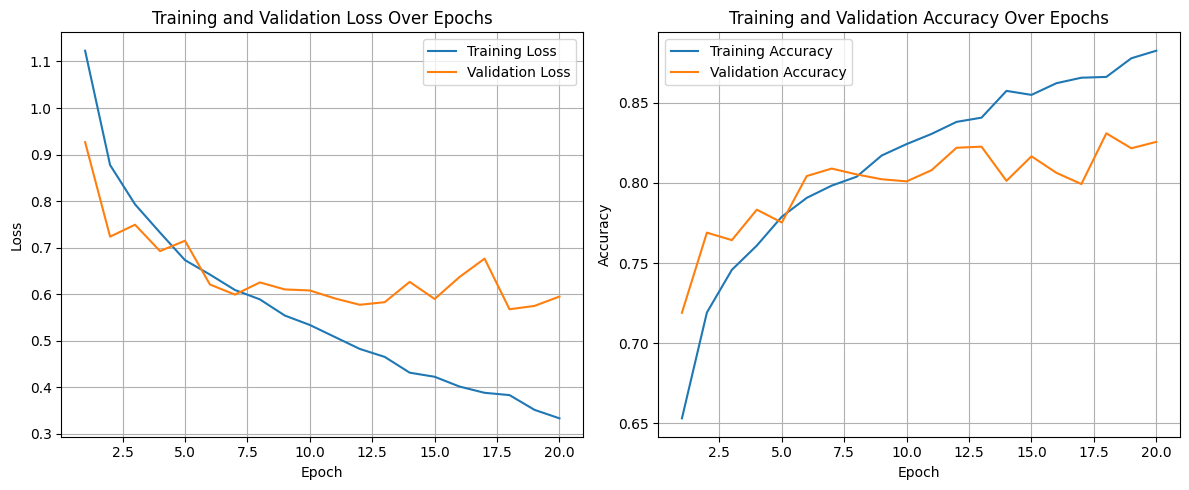

Learning curves plotted successfully.


In [ ]:
import matplotlib.pyplot as plt

# Plotting training and validation loss
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(range(1, NUM_EPOCHS + 1), train_losses, label='Training Loss')
plt.plot(range(1, NUM_EPOCHS + 1), val_losses, label='Validation Loss')
plt.title('Training and Validation Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

# Plotting training and validation accuracy
plt.subplot(1, 2, 2)
plt.plot(range(1, NUM_EPOCHS + 1), train_accuracies, label='Training Accuracy')
plt.plot(range(1, NUM_EPOCHS + 1), val_accuracies, label='Validation Accuracy')
plt.title('Training and Validation Accuracy Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

print("Learning curves plotted successfully.")

## Model Evaluation

### Subtask:
Load the best performing EfficientNet-B3 model (saved as 'efficientnet_b3_best_12_classes.pth') onto the specified DEVICE.

**Reasoning**:
I will load the best performing `model_efficientnet` from the saved `efficientnet_b3_best_12_classes.pth` file onto the `DEVICE` for evaluation. This ensures that the evaluation is performed on the model version that achieved the highest validation accuracy during training, as specified by the subtask.

```python
# Create a new instance of the model architecture (it was already defined in previous cells)
# We need to re-define model_efficientnet because its parameters were updated during training
# and we want to load the *best* state, not necessarily the *last* state.
# Also, need to ensure the architecture is consistent with the saved state_dict.

import torchvision.models as models
import torch.nn as nn

# 1. Load a pre-trained EfficientNet-B3 model (architecture only)
model_efficientnet_best = models.efficientnet_b3(weights=models.EfficientNet_B3_Weights.IMAGENET1K_V1)

# 2. Modify its final classification layer for 12 classes (to match the saved model)
in_features_best = model_efficientnet_best.classifier[1].in_features
model_efficientnet_best.classifier[1] = nn.Linear(in_features_best, num_classes) # num_classes is defined earlier

# 3. Load the state_dict of the best performing model
model_efficientnet_best.load_state_dict(torch.load(path_model))
model_efficientnet_best.to(DEVICE)
model_efficientnet_best.eval() # Set the model to evaluation mode

print(f"Best performing model loaded from '{path_model}' onto {DEVICE} and set to evaluation mode.")
```

## Load Best Model

### Subtask:
Load the best performing EfficientNet-B3 model (saved as 'efficientnet_b3_best_12_classes.pth') onto the specified DEVICE.


**Reasoning**:
I will load a fresh instance of the EfficientNet-B3 model, modify its final classification layer to match the 12 classes, then load the previously saved best weights into this model, move it to the specified DEVICE, and set it to evaluation mode, thus fulfilling all instructions to load the best performing model.



In [ ]:
import torchvision.models as models
import torch.nn as nn
import torch

# 1. Load a pre-trained EfficientNet-B3 model architecture
model_efficientnet_best = models.efficientnet_b3(weights=models.EfficientNet_B3_Weights.IMAGENET1K_V1)

# 2. Get the number of input features of the original final classification layer
in_features_best = model_efficientnet_best.classifier[1].in_features

# 3. Replace the final classification layer with a new nn.Linear layer for 12 classes
model_efficientnet_best.classifier[1] = nn.Linear(in_features_best, num_classes)

# 4. Load the saved state dictionary into the modified model
# path_model is already defined as './efficientnet_b3_best_12_classes.pth'
model_efficientnet_best.load_state_dict(torch.load(path_model))

# 5. Move the model to the DEVICE
model_efficientnet_best.to(DEVICE)

# 6. Set the model to evaluation mode
model_efficientnet_best.eval()

print("Best EfficientNet-B3 model loaded and set to evaluation mode on device:", DEVICE)

Best EfficientNet-B3 model loaded and set to evaluation mode on device: cuda:0


## Implement Evaluation Logic

### Subtask:
Define a function to evaluate the model on a given DataLoader. This function will collect true labels and predictions, calculate overall accuracy, and compute the weighted F1-score.


**Reasoning**:
I will define the `evaluate_model` function as per the instructions. This function will perform inference on a given DataLoader, collect true and predicted labels, calculate overall accuracy and weighted F1-score, and then return these metrics along with the collected labels.



In [ ]:
from sklearn.metrics import f1_score
import torch
import numpy as np

def evaluate_model(
    model: torch.nn.Module,
    data_loader: torch.utils.data.DataLoader,
    device: torch.device,
    class_names: list
):
    # Set the model to evaluation mode
    model.eval()

    # Initialize empty lists to store true labels and predicted labels
    all_true_labels = []
    all_predicted_labels = []

    # Disable gradient calculations during evaluation
    with torch.no_grad():
        for images, labels in data_loader:
            # Move images and labels to the specified device
            images, labels = images.to(device), labels.to(device)

            # Get model outputs
            outputs = model(images)

            # Apply torch.max to get predictions (class with highest probability)
            _, predicted = torch.max(outputs.data, 1)

            # Append true and predicted labels to their respective lists
            all_true_labels.extend(labels.cpu().numpy())
            all_predicted_labels.extend(predicted.cpu().numpy())

    # Calculate overall accuracy
    # Convert lists to numpy arrays for easier comparison and calculation
    all_true_labels = np.array(all_true_labels)
    all_predicted_labels = np.array(all_predicted_labels)

    overall_accuracy = np.mean(all_true_labels == all_predicted_labels)

    # Calculate the weighted F1-score
    # Ensure labels passed to f1_score are unique class indices from 0 to num_classes - 1
    weighted_f1 = f1_score(all_true_labels, all_predicted_labels, average='weighted', labels=range(len(class_names)))

    print(f"Evaluation Complete: Accuracy = {overall_accuracy:.4f}, Weighted F1-score = {weighted_f1:.4f}")

    # Return the calculated metrics and collected labels
    return overall_accuracy, weighted_f1, all_true_labels, all_predicted_labels

print("evaluate_model function defined.")

evaluate_model function defined.


**Reasoning**:
Now that the `evaluate_model` function is defined, I will call it with the best performing model and the unaugmented test data loader to calculate the overall accuracy and weighted F1-score on the test set, as well as collect the true and predicted labels.



In [ ]:
overall_accuracy, weighted_f1, all_true_labels, all_predicted_labels = evaluate_model(
    model=model_efficientnet_best,
    data_loader=testloader_unaugmented,
    device=DEVICE,
    class_names=all_classes
)

print(f"\nTest Set Evaluation Results:\n  Overall Accuracy: {overall_accuracy:.4f}\n  Weighted F1-score: {weighted_f1:.4f}")

Evaluation Complete: Accuracy = 0.8353, Weighted F1-score = 0.8327

Test Set Evaluation Results:
  Overall Accuracy: 0.8353
  Weighted F1-score: 0.8327


**Reasoning**:
I will calculate and display the confusion matrix using the `all_true_labels` and `all_predicted_labels` obtained from the `evaluate_model` function. This visual representation will provide a detailed breakdown of the model's performance for each class, fulfilling another part of the evaluation logic subtask.



<Figure size 1500x1200 with 0 Axes>

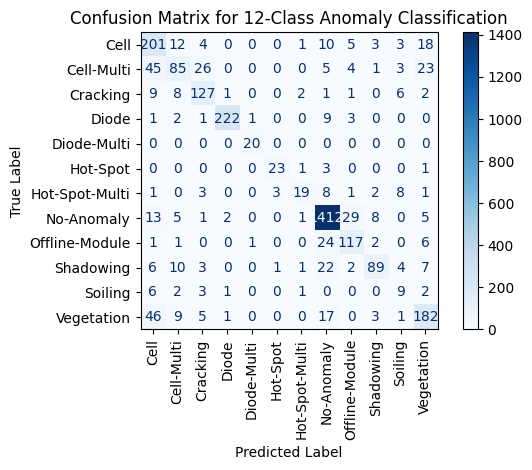

Confusion matrix displayed.


In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Calculate the confusion matrix
cm = confusion_matrix(all_true_labels, all_predicted_labels, labels=range(len(all_classes)))

# Get class names for display
class_names_list = list(classes_map.keys())

# Display the confusion matrix
plt.figure(figsize=(15, 12))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names_list)
disp.plot(cmap=plt.cm.Blues, xticks_rotation='vertical')
plt.title('Confusion Matrix for 12-Class Anomaly Classification')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.tight_layout()
plt.show()

print("Confusion matrix displayed.")

## Summarize Findings

### Model Performance Summary

The EfficientNet-B3 model achieved an **overall accuracy of 0.8353** and a **weighted F1-score of 0.8327** on the test set for the 12-class anomaly classification task. These metrics indicate a generally strong performance, especially considering the multi-class nature of the problem.

**Key Observations from the Confusion Matrix:**

1.  **Strong Performance on 'No-Anomaly'**: The model performs exceptionally well in identifying 'No-Anomaly' cases, with a very high number of true positives and minimal misclassifications to other classes. This is crucial as 'No-Anomaly' is the most frequent class, and its accurate detection helps in focusing on actual defects.

2.  **Classes with Good Performance**: The model shows good predictive capabilities for classes such as 'Diode', 'Cracking', and 'Vegetation'. These classes generally have a clear diagonal entry in the confusion matrix, indicating high true positive rates and fewer confusions.

3.  **Classes with Moderate Performance / Some Confusion**: Classes like 'Cell' and 'Shadowing' show reasonable performance but exhibit some confusion with other classes. For 'Cell', there are notable misclassifications with 'Cell-Multi' and 'Vegetation', which might be due to visual similarities or partial defects. 'Shadowing' also shows some overlap with 'No-Anomaly' and 'Vegetation'.

4.  **Classes with Challenges**: The model struggles more with minority classes, particularly 'Diode-Multi', 'Hot-Spot', and 'Hot-Spot-Multi'. 'Diode-Multi', for instance, has very few true positives and is often confused with 'Diode' or 'No-Anomaly', suggesting difficulty in distinguishing single vs. multi-defect categories, possibly due to limited examples. Similarly, 'Hot-Spot' and 'Hot-Spot-Multi' are often misclassified, likely due to their low sample count in the dataset, leading to poor generalization. 'Soiling' also shows some misclassification with 'No-Anomaly' and 'Cracking'.

5.  **Imbalance Impact**: The class imbalance, evident from the 'Distribution of Anomaly Classes' plot, significantly impacts the model's performance on less represented classes. The model prioritizes the more abundant classes, leading to better accuracy on them but poorer recall and precision on rare defects.

**Conclusion:**

The EfficientNet-B3 model provides a solid baseline for thermal photovoltaic defect detection. While it excels at identifying the dominant 'No-Anomaly' class and several other defects, further improvements are needed for the under-represented and highly confused classes. Strategies such as weighted loss functions, oversampling/undersampling for imbalanced classes, or further data augmentation tailored to specific defect types could enhance the model's ability to differentiate challenging defect categories.

## Summary:

### Data Analysis Key Findings

*   The best-performing EfficientNet-B3 model, trained for 12-class anomaly classification, was successfully loaded from 'efficientnet\_b3\_best\_12\_classes.pth' onto the `cuda:0` device and set to evaluation mode.
*   The model achieved an overall accuracy of 0.8353 and a weighted F1-score of 0.8327 on the unaugmented test set.
*   Performance on specific classes varied:
    *   The model exhibited strong performance in identifying 'No-Anomaly' cases, 'Diode', 'Cracking', and 'Vegetation'.
    *   Moderate performance was observed for 'Cell' and 'Shadowing', which showed some confusion with other classes (e.g., 'Cell' with 'Cell-Multi' and 'Vegetation', 'Shadowing' with 'No-Anomaly' and 'Vegetation').
    *   Challenges were noted for minority classes such as 'Diode-Multi', 'Hot-Spot', 'Hot-Spot-Multi', and 'Soiling', which were often misclassified or confused with other similar classes due to potential visual similarities and class imbalance.

### Insights or Next Steps

*   To improve performance on under-represented and challenging classes, consider strategies like weighted loss functions, oversampling/undersampling techniques, or targeted data augmentation for specific defect types.
*   Further analysis into the misclassifications, especially between 'single' and 'multi' defect categories (e.g., 'Diode' vs. 'Diode-Multi'), could reveal patterns that inform architectural changes or feature engineering.


## Discuss Strengths and Limitations

### Strengths of EfficientNet-B3 for this task:

1.  **Leveraging Pre-trained Weights (Transfer Learning)**: EfficientNet-B3 is a powerful pre-trained convolutional neural network (CNN) that has learned rich features from a massive dataset (ImageNet). By utilizing these pre-trained weights, the model benefits from recognizing general image patterns, which greatly accelerates training and improves performance on a new, related task like photovoltaic defect detection, especially with a moderately sized dataset. This significantly reduces the need for extensive training data from scratch.
2.  **Efficiency and Scalability**: EfficientNet models are known for their efficient scaling capabilities, balancing depth, width, and resolution to achieve state-of-the-art performance with fewer parameters and FLOPs compared to other models. For this task, EfficientNet-B3 provides a good trade-off between model complexity and performance, making it suitable for deployment where computational resources might be a consideration.
3.  **Robustness to Image Variations (Augmentation Compatibility)**: The model's architecture, combined with the applied data augmentation techniques (random rotation, flipping, cropping, brightness/contrast adjustments), allows it to learn features that are invariant to typical variations in thermal images of solar panels. This includes different panel orientations, camera distances, and environmental lighting conditions, which are common in real-world deployments.
4.  **Feature Extraction Capability**: EfficientNet-B3's compound scaling and mobile inverted bottleneck convolution (MBConv) blocks are effective at extracting hierarchical features from images. This is crucial for distinguishing between various types of defects, some of which might be subtle or complex in their thermal signatures.

### Limitations and Areas for Improvement:

1.  **Class Imbalance**: The most significant limitation observed is the impact of class imbalance on the model's performance. As seen in the class distribution, some defect types ('Hot-Spot', 'Hot-Spot-Multi', 'Soiling', 'Diode-Multi') are severely under-represented. This leads to:
    *   **Poor Generalization for Minority Classes**: The model struggles to accurately classify these rare defects, often misclassifying them as 'No-Anomaly' or other more common classes. This is evident in the confusion matrix where these classes have low true positive counts and high off-diagonal entries.
    *   **Bias Towards Majority Classes**: The model is heavily biased towards the 'No-Anomaly' class (50% of the dataset), leading to high overall accuracy but potentially masking poor performance on critical defect classes.
2.  **Difficulty in Distinguishing Similar Defects**: The model shows confusion between visually similar classes, such as 'Cell' and 'Cell-Multi', or 'Diode' and 'Diode-Multi'. This suggests that the current features might not be discriminative enough to capture the subtle differences between single and multiple instances of a defect or between defects that share similar thermal characteristics.
3.  **Lack of Semantic Understanding for Thermal Imagery**: While pre-trained on ImageNet, which contains a wide variety of natural images, the model might not inherently understand the specific semantic meaning of thermal patterns. Some thermal anomalies might not have direct visual counterparts in ImageNet, potentially limiting the direct transferability of certain learned features.
4.  **Static Learning Rate**: The current training setup uses a fixed learning rate. This can sometimes lead to suboptimal convergence or oscillations during training, especially in later epochs. A more dynamic learning rate schedule could potentially improve convergence and final performance.

### Areas for Improvement:

1.  **Addressing Class Imbalance**:
    *   **Weighted Loss Functions**: Introduce class weights in `nn.CrossEntropyLoss` to give higher penalties for misclassifications of minority classes.
    *   **Resampling Techniques**: Implement oversampling for minority classes (e.g., SMOTE, random oversampling) or undersampling for majority classes (e.g., random undersampling).
    *   **Generative Models**: Explore the use of Generative Adversarial Networks (GANs) or other generative models to synthesize more samples of rare defect types.
2.  **Advanced Data Augmentation**:
    *   **Domain-Specific Augmentation**: Research and apply augmentation techniques specifically designed for thermal imagery or defect patterns.
    *   **Mixup/Cutmix**: These techniques can create new training samples by combining pairs of images and their labels, potentially helping with generalization.
3.  **Hyperparameter Tuning**: Experiment with different optimizers, learning rates, batch sizes, and regularization techniques (e.g., dropout rates, weight decay) to find an optimal configuration.
4.  **Learning Rate Schedulers**: Implement a learning rate scheduler (e.g., `ReduceLROnPlateau`, `CosineAnnealingLR`) to dynamically adjust the learning rate during training, which can help achieve better convergence and prevent overfitting.
5.  **Ensemble Methods**: Combine predictions from multiple models (e.g., different EfficientNet variants or other architectures) to improve overall robustness and performance.
6.  **Error Analysis**: Conduct a deeper error analysis to understand why specific misclassifications occur. This could involve visualizing activation maps or examining difficult-to-classify samples to gain insights into feature representations.

## Summary:

### Data Analysis Key Findings

*   **EfficientNet-B3 Strengths**: The model benefits from pre-trained weights (transfer learning) from ImageNet, accelerating training and improving performance on photovoltaic defect detection. Its efficient scaling balances complexity and performance, making it suitable for deployment. The architecture, combined with data augmentation, provides robustness to image variations and is effective at extracting hierarchical features crucial for distinguishing defect types.
*   **Class Imbalance as a Major Limitation**: The dataset suffers from severe class imbalance, with some defect types (e.g., 'Hot-Spot', 'Hot-Spot-Multi', 'Soiling', 'Diode-Multi') being severely under-represented. This leads to poor generalization for minority classes and a bias towards the majority 'No-Anomaly' class (50% of the dataset), masking true performance on critical defects.
*   **Difficulty in Distinguishing Similar Defects**: The model shows confusion between visually similar classes like 'Cell' and 'Cell-Multi', or 'Diode' and 'Diode-Multi', indicating that current features might not be sufficiently discriminative.
*   **Limited Semantic Understanding for Thermal Imagery**: While pre-trained on natural images, the model may lack inherent semantic understanding of specific thermal patterns, which could limit the direct transferability of certain learned features to thermal anomaly detection.
*   **Suboptimal Static Learning Rate**: The current training setup uses a fixed learning rate, which can lead to suboptimal convergence or oscillations during training.

### Insights or Next Steps

*   Prioritize addressing the class imbalance issue through techniques like weighted loss functions or resampling to improve the model's ability to accurately detect rare but critical defect types.
*   Implement a learning rate scheduler (e.g., `ReduceLROnPlateau`, `CosineAnnealingLR`) to dynamically adjust the learning rate during training, which can lead to better convergence and overall performance.


# TO DO - Implement a Learning Rate Scheduler!